In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import cv2
from albumentations import Compose, Normalize, VerticalFlip, HorizontalFlip
from albumentations import Rotate, Resize, LongestMaxSize, PadIfNeeded, BboxParams

from Pytorch.utils import Normalize_bbox_to_0_1, Convert_bbox_from_TLWH_to_TLBR
from Pytorch.utils import clamp, Bbox_clamp
from Pytorch.utils import Show_figure_with_bbox, Denormalize_tensor

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda

In [5]:
import os
import pickle
from os import path, listdir
from PIL import Image, ImageOps
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
exp_name = "Proto-RN50PT-SGD-SS-DA-FV-256"
epochs = 120
num_batch_train = 200
num_batch_val = 80
train_batch_size = 6
test_batch_size = 16

In [7]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [8]:
os.makedirs(parameters_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [9]:
training_classes = [0, 1, 7, 10, 13, 15, 17, 18, 19, 20, 26, 30]
test_classes = [2, 3, 6, 11, 12, 21, 22, 31, 16, 36]

In [10]:
training_support_set_size = len(training_classes)
test_support_set_size = len(test_classes)

In [11]:
print(training_support_set_size)
print(test_support_set_size)

12
10


In [12]:
class ZERO_SHOT_DATASET(tf.keras.utils.Sequence):
    def __init__(self,
        root_dirpath,
        images_dirpath,
        annotations_path,
        L_classes_idx_filter,
        support_set_size=10,
        image_id_key="image_id",
        category_id_key="category_id",
        F_image_id_to_relative_path=None,
        augmentation=True,
        desired_size=224,
        batch_size=2,
        num_batch=1):
        
        self.root_dirpath = root_dirpath
        self.images_dirpath = images_dirpath
        self.annotations_path = annotations_path
        self.image_id_key=image_id_key
        self.category_id_key=category_id_key
        self.L_classes_idx_filter = L_classes_idx_filter
        self.support_set_size = support_set_size
        self.F_image_id_to_relative_path = F_image_id_to_relative_path
        self.augmentation = augmentation
        self.desired_size = desired_size
        self.batch_size = batch_size
        self.num_batch = num_batch

        with open(self.annotations_path) as f:
            self.D_instances = json.load(f)
            self.L_annotations = self.D_instances['annotations']
            self.L_categories = self.D_instances['categories']

        # list of real class indices in COCO dataset
        self.L_real_class_idx = [x['id'] for x in self.L_categories]
        # zero-based class indices of COCO dataset (0-79)
        self.L_class_idx = range(len(self.L_real_class_idx))
        # dict to map real class indices to zero-based indices
        self.D_real_class_idx_to_class_idx = { real_class_idx : class_idx for class_idx, real_class_idx in enumerate(self.L_real_class_idx)}

        # dict to map zero based indices to the relative annotations
        self.D_class_to_annotations = self.Create_class_to_annotations_dict()

        # filter zero-based class indices which have no annotations
        self.L_not_empty_class_idx = [class_idx for class_idx in self.L_class_idx if len(self.D_class_to_annotations[class_idx])>0]
        # filter only specified class indices
        self.L_filtered_class_idx = [class_idx for class_idx in self.L_not_empty_class_idx if class_idx in self.L_classes_idx_filter]
        
        augmentation_transform = Compose(
            [
                VerticalFlip(p=0.5),
                HorizontalFlip(p=0.5),
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT)
            ]
        )

        loading_transform = Compose(
            [
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT)
            ]
        )

        self.transform = augmentation_transform if self.augmentation else loading_transform

    def Create_class_to_annotations_dict(self):
        '''
        Create a dictionary of type (int : list) which map to each zero-based class index a list of
        all the COCO annotations of a specific class using self.D_real_class_idx_to_class_idx as map
        '''
        # init empty dictionary with zero-based class indices
        D_class_to_annotations = {idx : [] for idx in self.L_class_idx}

        for annotation in self.L_annotations:
            real_class_idx = annotation[self.category_id_key]
            class_idx = self.D_real_class_idx_to_class_idx[real_class_idx]
            D_class_to_annotations[class_idx].append(annotation)

        return D_class_to_annotations

    def Get_num_classes(self):
        return len(self.L_categories)

    def Get_class_idx_description(self, class_idx):
        return self.L_categories[class_idx]

    def Get_random_image_and_bbox_from_class(self, class_idx):
        try:
            D_item_annotation = np.random.choice(self.D_class_to_annotations[class_idx])
            item_image_id = D_item_annotation[self.image_id_key]
            if(self.F_image_id_to_relative_path):
                    image_relative_path = self.F_image_id_to_relative_path(item_image_id)
            else:
                image_relative_path = item_image_id
            item_PIL_image = Image.open(path.join(self.images_dirpath, image_relative_path)).convert('RGB')
            image_width, image_height = item_PIL_image.size

            item_bbox = Bbox_clamp(D_item_annotation['bbox'], image_width, image_height)
            item_PIL_image_patch = item_PIL_image.crop((item_bbox[0], item_bbox[1], item_bbox[0]+item_bbox[2], item_bbox[1]+item_bbox[3]))
            D_item_transformed = self.transform(image = np.array(item_PIL_image_patch))
            T_image = tf.keras.preprocessing.image.img_to_array(D_item_transformed['image'])
            return T_image
        except:
            return self.Get_random_image_and_bbox_from_class(class_idx)

    def __getitem__(self, index):

        T_batch_images = np.zeros((self.batch_size, self.support_set_size+1, self.desired_size, self.desired_size, 3))
        T_batch_gt = np.zeros((self.batch_size,))
        
        for batch_index in range(self.batch_size):
            L_support_idx = np.random.choice(self.L_filtered_class_idx, size=self.support_set_size, replace=False)
            np.random.shuffle(L_support_idx)
            L_target_idx = np.random.choice(len(L_support_idx))
            target_class_idx = L_support_idx[L_target_idx]
            L_support_and_target_idx = np.append(L_support_idx, target_class_idx)
            for internal_index in range(self.support_set_size+1):
                T_image = self.Get_random_image_and_bbox_from_class(L_support_and_target_idx[internal_index])
                T_batch_images[batch_index, internal_index] = T_image
                
            T_batch_gt[batch_index] = L_target_idx
        T_batch_images = tf.keras.applications.resnet.preprocess_input(T_batch_images)
        return T_batch_images, T_batch_gt

    def __len__(self):
        return self.num_batch#*self.batch_size

In [13]:
DSET_training = ZERO_SHOT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/train_dataset.json',
    L_classes_idx_filter = training_classes,
    support_set_size=training_support_set_size,
    image_id_key="path",
    category_id_key="class_id",
    augmentation = True,
    batch_size = train_batch_size,
    num_batch = num_batch_train
)

In [14]:
DSET_validation = ZERO_SHOT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/val_dataset.json',
    L_classes_idx_filter = test_classes,
    support_set_size=test_support_set_size,
    image_id_key="path",
    category_id_key="class_id",
    augmentation = False,
    batch_size = test_batch_size,
    num_batch = num_batch_val
)

In [15]:
def denorm(y):
  mean = [103.939, 116.779, 123.68]
  x = np.zeros(y.shape)
  x[:, :, 2] = y[:, :, 0] + mean[0]
  x[:, :, 1] = y[:, :, 1] + mean[1]
  x[:, :, 0] = y[:, :, 2] + mean[2]
  return x

In [16]:
import matplotlib.pyplot as plt
def show_item(sample, n_rows=5, n_cols=5):
    fig = plt.figure(figsize=(30, 12))
    fig.patch.set_alpha(0.5)
    gs = fig.add_gridspec(n_rows+1, n_cols)
        
    r = 1
    c = 0

    for idx, img in enumerate(sample):
      ax = fig.add_subplot(gs[r, c])
      c+=1
      if c == n_cols:
          c=0
          r+=1
      ax.imshow(denorm(img)/255)
      ax.axis('off')
      ax.title.set_text(idx)
    plt.show()

In [17]:
train_batch_example = DSET_training[0]
test_batch_example = DSET_validation[0]

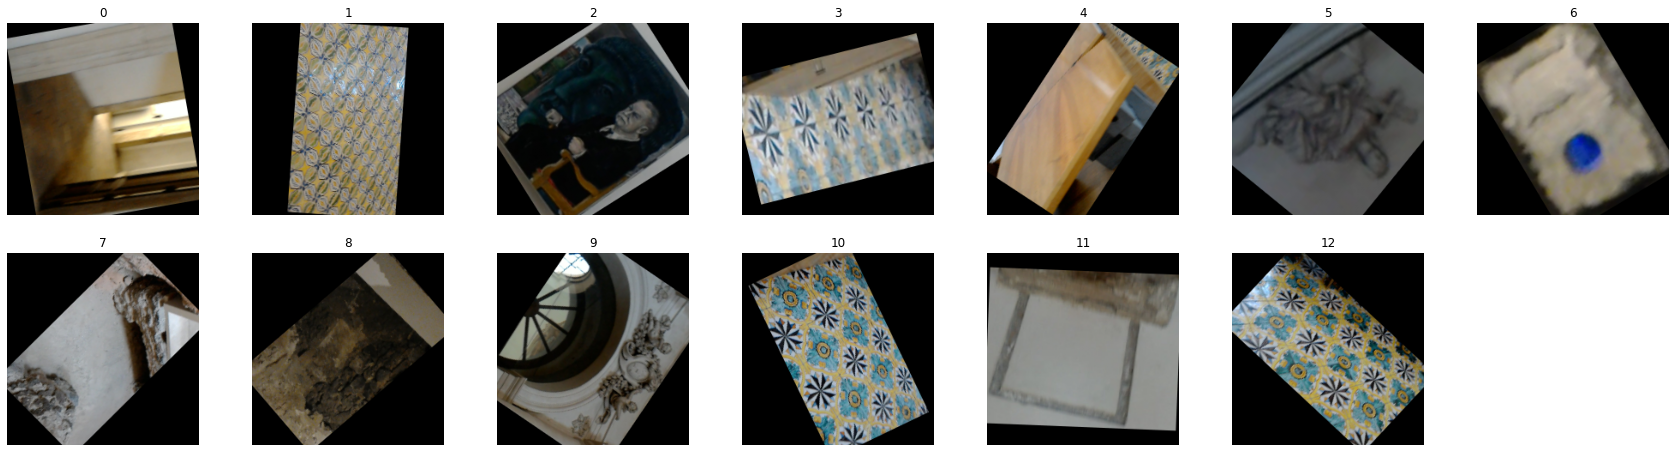

10.0


In [18]:
show_item(train_batch_example[0][0], n_rows=2, n_cols=7)
print(train_batch_example[1][0])

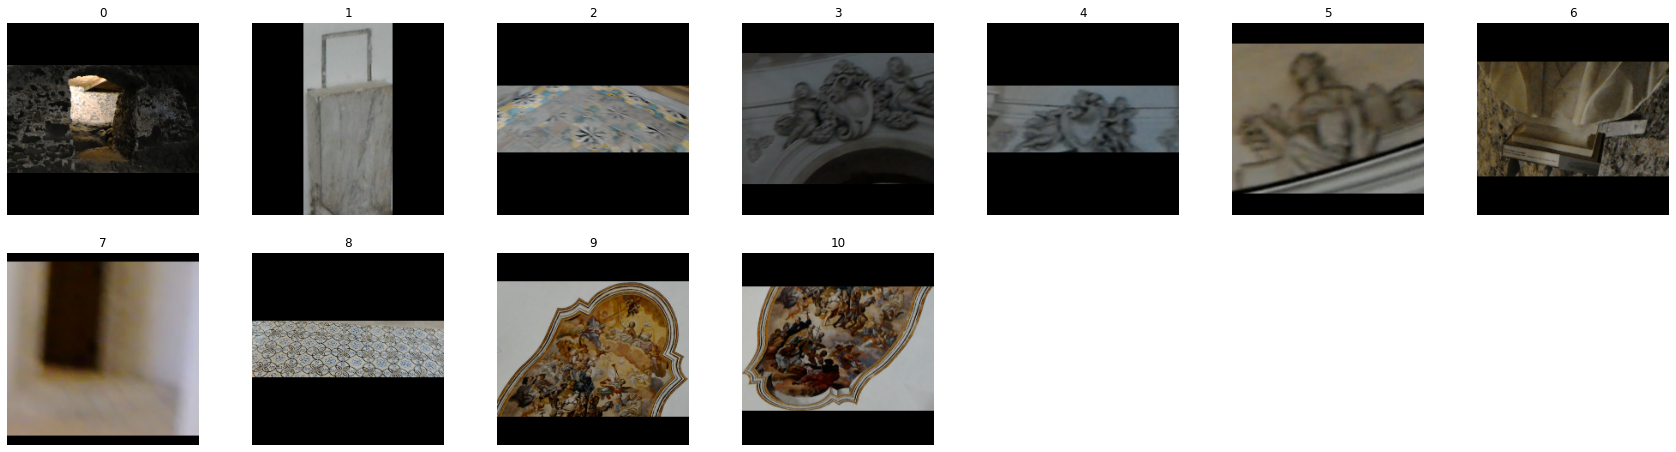

9.0


In [19]:
show_item(test_batch_example[0][0], n_rows=2, n_cols=7)
print(test_batch_example[1][0])

In [20]:
feature_extractor = tf.keras.applications.resnet.ResNet50(include_top=False, weights="imagenet", pooling='avg')
#feature_extractor.load_weights("drive/My Drive/Weights/test_weights.hdf5")
#feature_extractor = tf.keras.applications.resnet.ResNet50(include_top=False, weights=None, pooling='avg')

In [21]:
class DistanceLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    kwargs["dynamic"] = True
    super(DistanceLayer, self).__init__(**kwargs)

  def call(self, inputs):
    support_set_size = inputs.shape[1]-1
    encoded_support_set = inputs[:, :support_set_size]
    encoded_target = tf.keras.backend.repeat(inputs[:, inputs.shape[1]-1], support_set_size)
    return tf.norm(encoded_support_set-encoded_target, ord='euclidean', keepdims=False, axis=2)

  def compute_output_shape(self, input_shape):
    return tf.TensorShape([None, None])

In [22]:
class FeatureExtractionLayer(tf.keras.layers.Layer):
  def __init__(self, feature_extractor, **kwargs):
    kwargs["dynamic"] = True
    super(FeatureExtractionLayer, self).__init__(**kwargs)
    self.feature_extractor = feature_extractor
    self.dense = tf.keras.models.Sequential([
        self.feature_extractor,
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(256, input_shape=(2048,)),
        tf.keras.layers.Activation('relu')
    ])
    self.support_has_been_fixed = False
    self.encoded_support_set = None

  def call(self, inputs, training=None):
    if training:
      self.encoded_list = [self.dense(inputs[:, i]) for i in range(inputs.shape[1])]
      self.support_has_been_fixed = False
    else:
      if not self.support_has_been_fixed:
        self.encoded_support_set = [self.dense(inputs[:1, i]) for i in range(inputs.shape[1]-1)]
        self.encoded_support_set = tf.keras.backend.stack(self.encoded_support_set, axis=1)
        self.support_has_been_fixed = True
      batch_size = inputs.shape[0]
      target_embeddings = self.dense(inputs[:, -1])
      target_embeddings = tf.keras.backend.expand_dims(target_embeddings, axis=1)
      endoded_support_set_batch = tf.keras.backend.repeat_elements(self.encoded_support_set, batch_size, axis=0)
      return tf.keras.backend.concatenate((endoded_support_set_batch, target_embeddings), axis=1)
      
    return tf.keras.backend.stack(
      self.encoded_list,
      axis=1
    )

  def compute_output_shape(self, input_shape):
    return tf.TensorShape([None, None, 256])

In [23]:
def get_proto_model(feature_extractor, input_shape=(224, 224, 3)):
    """
        Model architecture
    """
    
    support_input = Input((None, *input_shape))

    f_extraction_layer = FeatureExtractionLayer(feature_extractor)
    distance_layer = DistanceLayer()
    
    # Generate the encodings (feature vectors) for the two images
    encoded_input = f_extraction_layer(support_input)
    euclidean_distances = distance_layer(encoded_input)

    prediction = tf.keras.layers.Activation('softmax')(-euclidean_distances)
    
    # Connect the inputs with the outputs
    proto_net = Model(inputs=support_input, outputs=prediction)
    
    # return the model
    return proto_net

In [24]:
model = get_proto_model(feature_extractor)
#model.load_weights(path.join("drive/My Drive/Weights/", exp_name, "weights.46-0.77.hdf5"))
#print(path.join("drive/My Drive/Weights/", exp_name, "weights.46-0.77.hdf5"))

In [25]:
import math
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 20.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=True)

Learning rate per epoch:


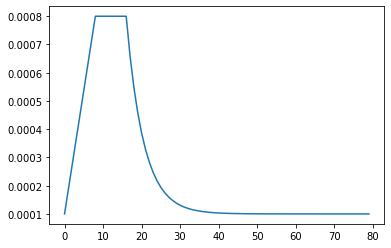

In [26]:
epochs = 80

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0008
rampup_epochs = 8
sustain_epochs = 8
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
#learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [27]:
adam = tf.keras.optimizers.Adam(amsgrad=True)

In [28]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.1,
    nesterov=False
)

In [29]:
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
weights_path = path.join(parameters_path, "weights.{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, save_weights_only=True)

In [31]:
tensorboard_callback  = tf.keras.callbacks.TensorBoard(
    log_dir = plots_path,
    #histogram_freq=1,
    write_graph=False
)

In [32]:
#model.evaluate(test_gen)

In [33]:
model.fit(DSET_training, epochs=80, validation_data=DSET_validation, shuffle=False, callbacks=[checkpoint, tensorboard_callback, learning_rate_scheduler])#, initial_epoch=46)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/80
  1/200 [..............................] - ETA: 0s - loss: 2.4404 - accuracy: 0.1667

KeyboardInterrupt: 